In [5]:
import pandas as pd
import numpy as np
import zipfile
import itertools
import os

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [6]:
!kaggle datasets download patricklford/amazon-alibaba-and-ebay-2013-2023

Dataset URL: https://www.kaggle.com/datasets/patricklford/amazon-alibaba-and-ebay-2013-2023
License(s): Attribution 4.0 International (CC BY 4.0)
amazon-alibaba-and-ebay-2013-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
zip_file_path = '/content/amazon-alibaba-and-ebay-2013-2023.zip'
extract_folder = '/content/amazon-alibaba-and-ebay-2013-2023'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

extracted_files = os.listdir(extract_folder)

In [43]:
df_amazon = pd.read_csv("/content/amazon-alibaba-and-ebay-2013-2023/Amazon.csv")
df_alibaba = pd.read_csv("/content/amazon-alibaba-and-ebay-2013-2023/Alibaba.csv")
df_ebay = pd.read_csv("/content/amazon-alibaba-and-ebay-2013-2023/eBay.csv")

df_amazon.head()

,Year,Billion USD
0,2013 Q1,16.1
1,2013 Q2,15.7
2,2013 Q3,17.1
3,2013 Q4,25.6
4,2014 Q1,19.7


In [9]:
df_amazon.dtypes

,0
Year,object
Billion USD,float64


In [44]:
def quarter_to_date(quarter_str):
    quarter_str = quarter_str.strip()
    if ' ' in quarter_str:
        year, quarter = quarter_str.split(' ')
        month = (int(quarter[-1]) - 1) * 3 + 1
        return f'{year}-{month:02d}-01'
    raise ValueError(f"Неправильный формат: {quarter_str}")

df_amazon['Date'] = pd.to_datetime(df_amazon['Year'].apply(quarter_to_date), errors='coerce')
df_alibaba['Date'] = pd.to_datetime(df_alibaba['Year'].apply(quarter_to_date), errors='coerce')
df_ebay['Date'] = pd.to_datetime(df_ebay['Year'].apply(quarter_to_date), errors='coerce')

df_amazon.drop('Year', axis=1, inplace=True)
df_alibaba.drop('Year', axis=1, inplace=True)
df_ebay.drop('Year', axis=1, inplace=True)

In [11]:
df_amazon.head()

,Billion USD,Date
0,16.1,2013-01-01
1,15.7,2013-04-01
2,17.1,2013-07-01
3,25.6,2013-10-01
4,19.7,2014-01-01


In [12]:
df_alibaba.head()

,Billion CYD,Date
0,6.79,2013-01-01
1,7.46,2013-04-01
2,11.60,2013-07-01
3,8.67,2013-10-01
4,10.80,2014-01-01


In [13]:
df_ebay.head()

,Billion USD,Date
0,3.75,2013-01-01
1,3.88,2013-04-01
2,3.89,2013-07-01
3,4.53,2013-10-01
4,4.00,2014-01-01


## VISUALIZING DATA

In [14]:
df_amazon.isnull().sum()

,0
Billion USD,0
Date,0


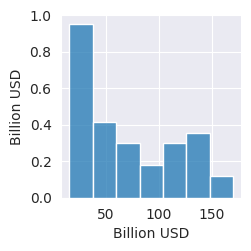

In [15]:
sns.pairplot(df_amazon)
plt.show()

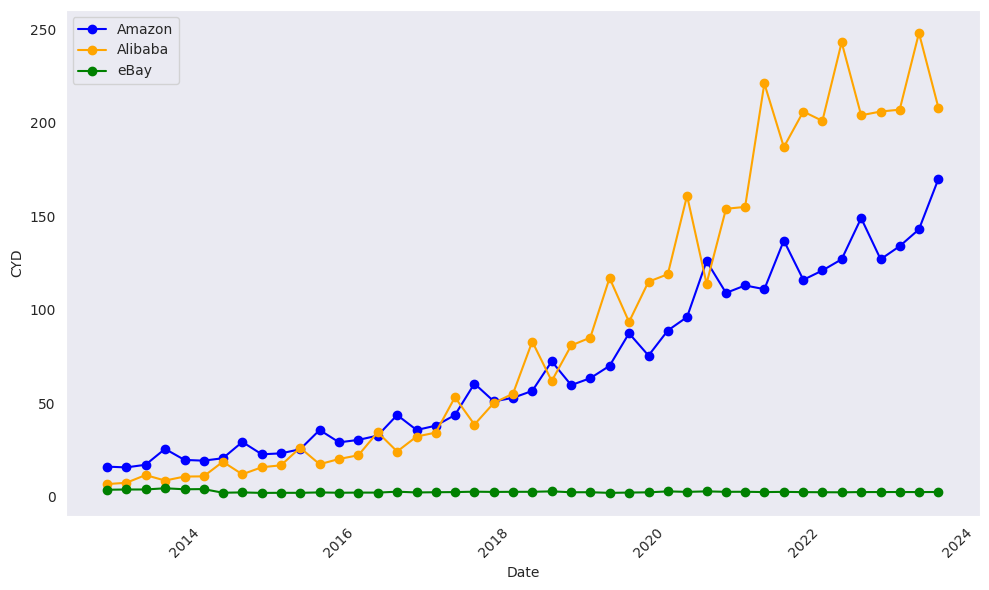

In [16]:
df_amazon = df_amazon.sort_values(by='Date')
df_alibaba = df_alibaba.sort_values(by='Date')
df_ebay = df_ebay.sort_values(by='Date')

plt.figure(figsize=(10, 6))
plt.plot(df_amazon['Date'], df_amazon['Billion USD'], marker='o', label='Amazon', color='blue')
plt.plot(df_alibaba['Date'], df_alibaba['Billion CYD'], marker='o', label='Alibaba', color='orange')
plt.plot(df_ebay['Date'], df_ebay['Billion USD'], marker='o', label='eBay', color='green')

plt.xlabel('Date')
plt.ylabel('CYD')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# SARIMAX

## AMAZON

In [35]:
df_amazon.set_index('Date', inplace=True)

amazon seasonal decomposition


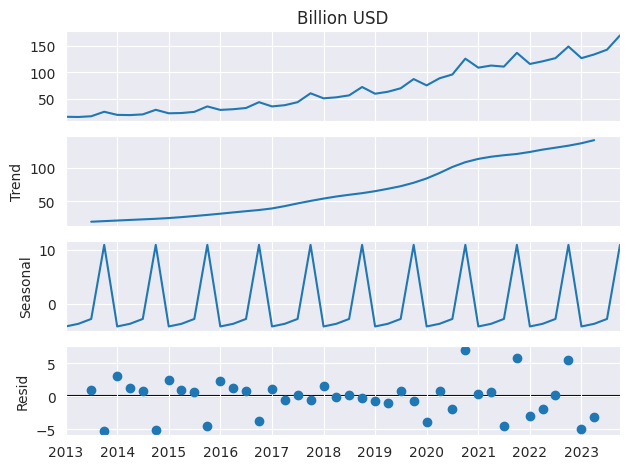

In [40]:
# Сезонная декомпозиция
print("amazon seasonal decomposition")
decomposition = seasonal_decompose(df_amazon['Billion USD'], model='additive')
decomposition.plot()
plt.show()

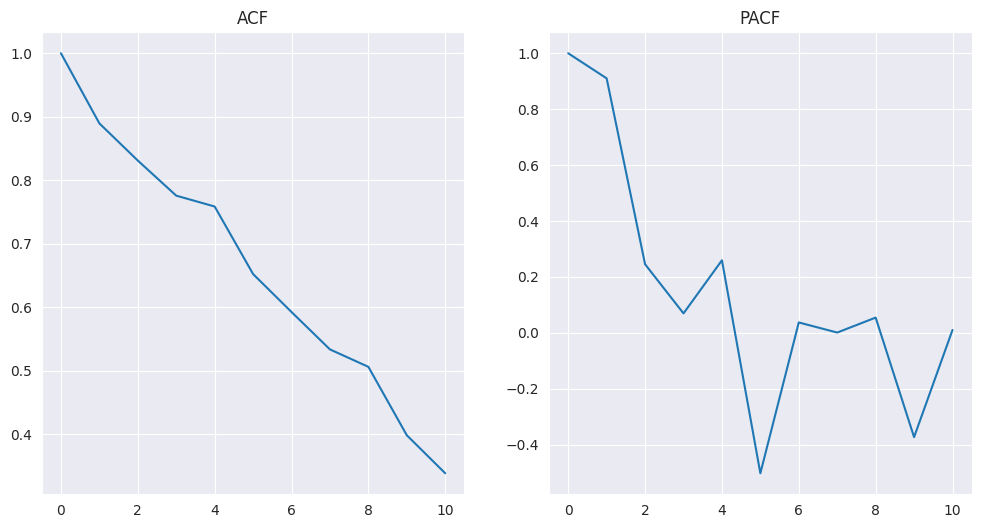

In [19]:
# Анализ ACF и PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf(df_amazon['Billion USD'], nlags=10))
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf(df_amazon['Billion USD'], nlags=10))
plt.title('PACF')
plt.show()

In [20]:
train_1, test_1 = df_amazon[:-6], df_amazon[-6:]

model_sarima = SARIMAX(train_1['Billion USD'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
model_fit_sarima = model_sarima.fit(disp=False)

forecast_sarima = model_fit_sarima.forecast(steps=len(test_1))
test_1['Forecast_SARIMA'] = forecast_sarima

rmse_sarima = np.sqrt(mean_squared_error(test_1['Billion USD'], test_1['Forecast_SARIMA']))
print(f"SARIMA RMSE: {rmse_sarima}")

SARIMA RMSE: 9.263467568953395


In [21]:
model_hw = ExponentialSmoothing(train_1['Billion USD'], seasonal='add', seasonal_periods=4)
model_fit_hw = model_hw.fit()
forecast_hw = model_fit_hw.forecast(steps=len(test_1))
test_1['Forecast_HW'] = forecast_hw

rmse_hw = np.sqrt(mean_squared_error(test_1['Billion USD'], test_1['Forecast_HW']))
print(f"Holt-Winters RMSE: {rmse_hw}")

Holt-Winters RMSE: 18.156138663984628


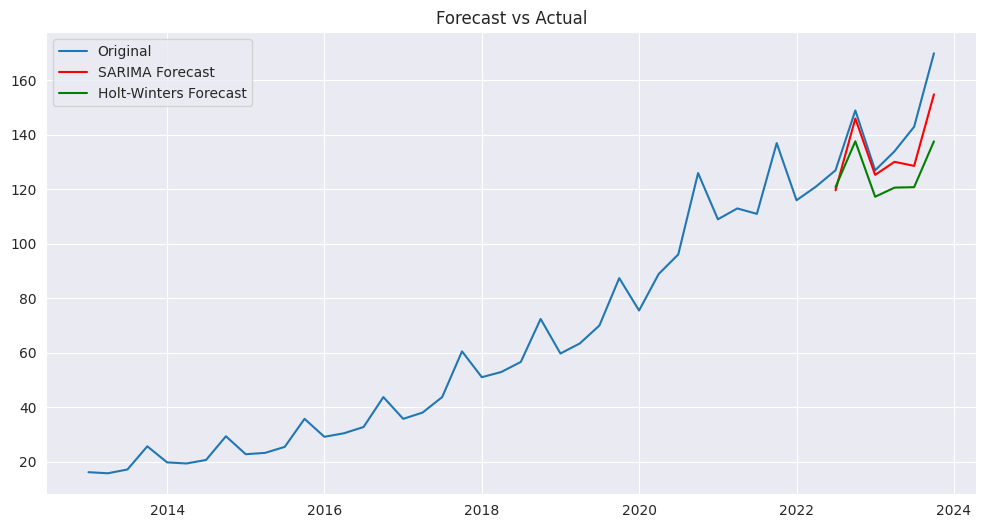

In [22]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_amazon.index, df_amazon['Billion USD'], label='Original')
plt.plot(test_1.index, test_1['Forecast_SARIMA'], label='SARIMA Forecast', color='red')
plt.plot(test_1.index, test_1['Forecast_HW'], label='Holt-Winters Forecast', color='green')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## ALIBABA

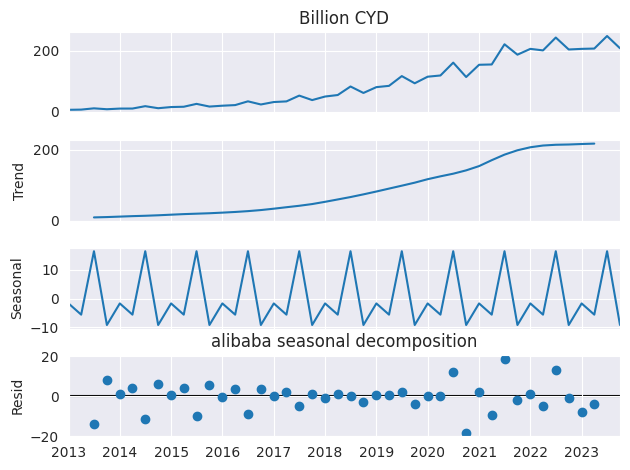

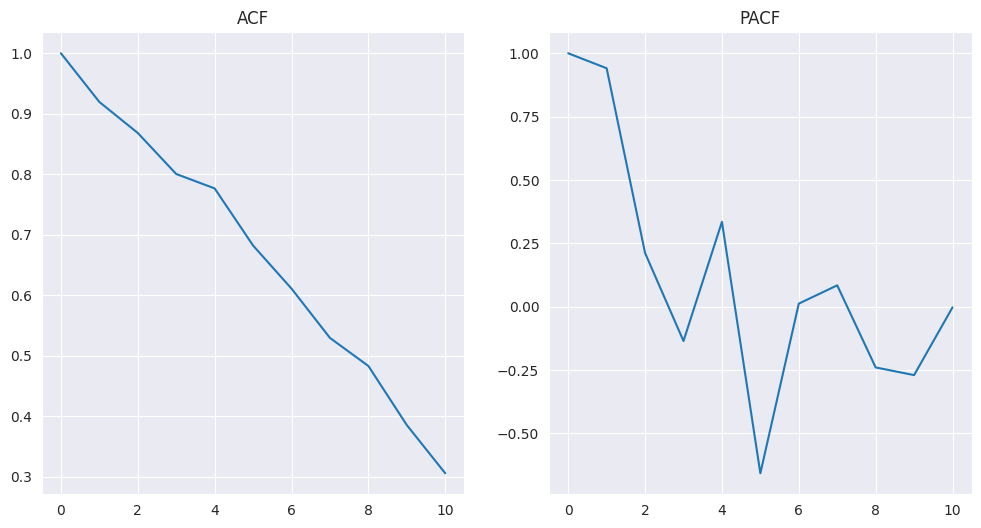

SARIMA RMSE: 62.26760926862873
Holt-Winters RMSE: 12.350712658210474


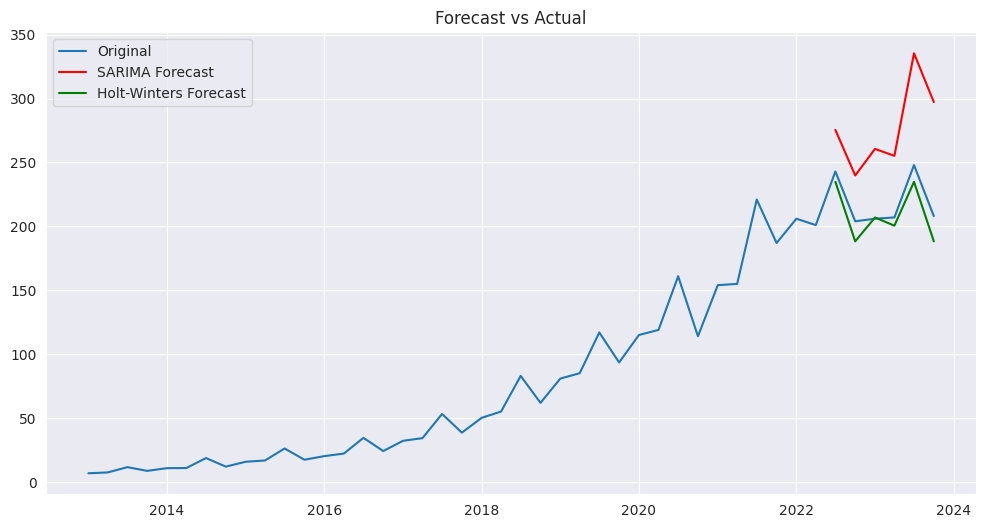

In [45]:
df_alibaba.set_index('Date', inplace=True)

# Сезонная декомпозиция
decomposition = seasonal_decompose(df_alibaba['Billion CYD'], model='additive')
decomposition.plot()
plt.title("alibaba seasonal decomposition")
plt.show()

# Анализ ACF и PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf(df_alibaba['Billion CYD'], nlags=10))
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf(df_alibaba['Billion CYD'], nlags=10))
plt.title('PACF')
plt.show()

train_2, test_2 = df_alibaba[:-6], df_alibaba[-6:]

model_sarima_2 = SARIMAX(train_2['Billion CYD'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
model_fit_sarima_2 = model_sarima_2.fit(disp=False)

forecast_sarima = model_fit_sarima_2.forecast(steps=len(test_2))
test_2['Forecast_SARIMA'] = forecast_sarima

rmse_sarima_2 = np.sqrt(mean_squared_error(test_2['Billion CYD'], test_2['Forecast_SARIMA']))
print(f"SARIMA RMSE: {rmse_sarima_2}")

model_hw_2 = ExponentialSmoothing(train_2['Billion CYD'], seasonal='add', seasonal_periods=4)
model_fit_hw_2 = model_hw_2.fit()
forecast_hw_2 = model_fit_hw_2.forecast(steps=len(test_2))
test_2['Forecast_HW'] = forecast_hw_2

rmse_hw_2 = np.sqrt(mean_squared_error(test_2['Billion CYD'], test_2['Forecast_HW']))
print(f"Holt-Winters RMSE: {rmse_hw_2}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_alibaba.index, df_alibaba['Billion CYD'], label='Original')
plt.plot(test_2.index, test_2['Forecast_SARIMA'], label='SARIMA Forecast', color='red')
plt.plot(test_2.index, test_2['Forecast_HW'], label='Holt-Winters Forecast', color='green')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## eBay

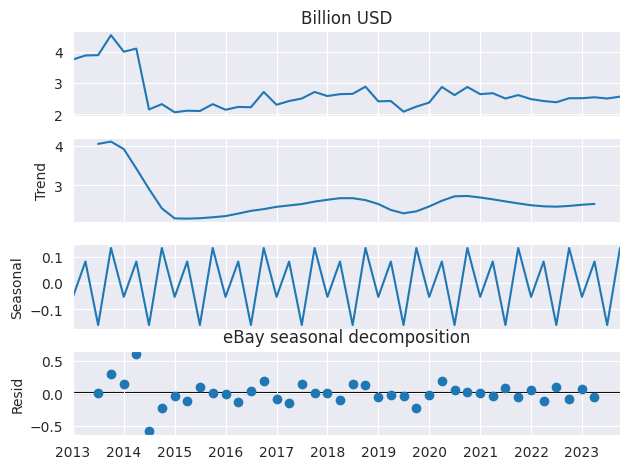

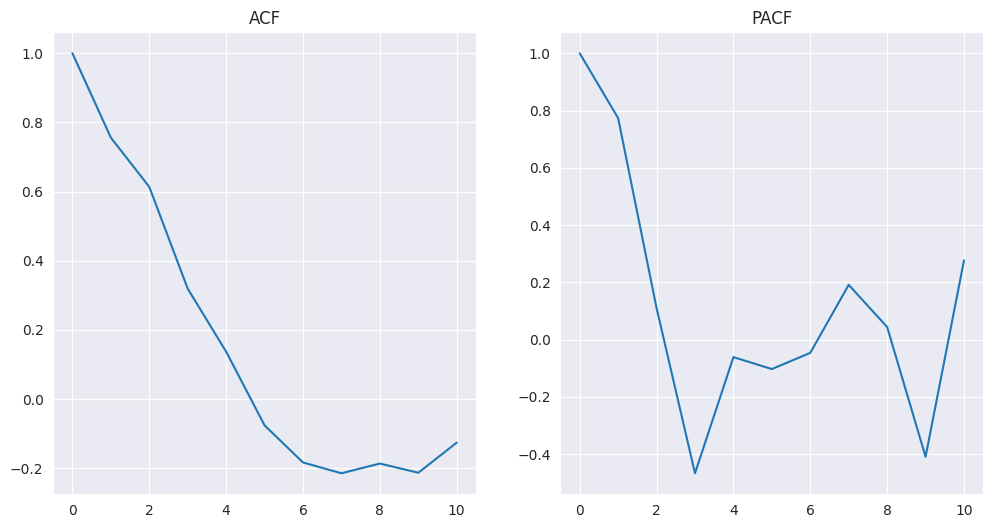

SARIMA RMSE: 0.3357852116568872
Holt-Winters RMSE: 0.1954294092808053


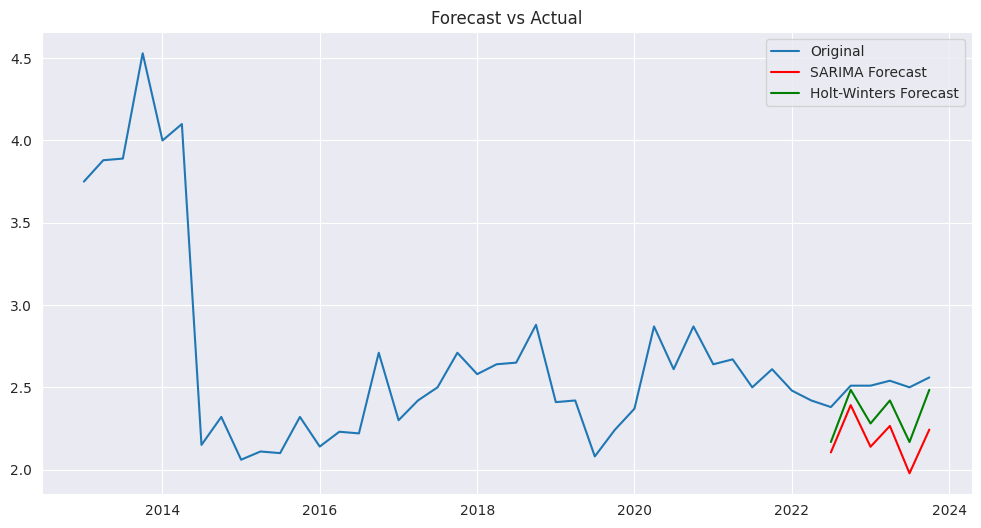

In [46]:
df_ebay.set_index('Date', inplace=True)

# Сезонная декомпозиция
decomposition = seasonal_decompose(df_ebay['Billion USD'], model='additive')
decomposition.plot()
plt.title("eBay seasonal decomposition")
plt.show()

# Анализ ACF и PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf(df_ebay['Billion USD'], nlags=10))
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf(df_ebay['Billion USD'], nlags=10))
plt.title('PACF')
plt.show()

train_3, test_3 = df_ebay[:-6], df_ebay[-6:]

model_sarima_3 = SARIMAX(train_3['Billion USD'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
model_fit_sarima_3 = model_sarima_3.fit(disp=False)

forecast_sarima = model_fit_sarima_3.forecast(steps=len(test_3))
test_3['Forecast_SARIMA'] = forecast_sarima

rmse_sarima_3 = np.sqrt(mean_squared_error(test_3['Billion USD'], test_3['Forecast_SARIMA']))
print(f"SARIMA RMSE: {rmse_sarima_3}")

model_hw_3 = ExponentialSmoothing(train_3['Billion USD'], seasonal='add', seasonal_periods=4)
model_fit_hw_3 = model_hw_3.fit()
forecast_hw_3 = model_fit_hw_3.forecast(steps=len(test_3))
test_3['Forecast_HW'] = forecast_hw_3

rmse_hw_3 = np.sqrt(mean_squared_error(test_3['Billion USD'], test_3['Forecast_HW']))
print(f"Holt-Winters RMSE: {rmse_hw_3}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_ebay.index, df_ebay['Billion USD'], label='Original')
plt.plot(test_3.index, test_3['Forecast_SARIMA'], label='SARIMA Forecast', color='red')
plt.plot(test_3.index, test_3['Forecast_HW'], label='Holt-Winters Forecast', color='green')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

## BONUS

In [47]:
def get_rmse(model, train, test):
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return np.sqrt(mean_squared_error(test['Billion USD'], forecast))

In [48]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]

best_aic = float("inf")
best_params = None

In [49]:
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df_amazon['Billion USD'], order=param, seasonal_order=seasonal_param)
            aic = model.fit(disp=False).aic
            if aic < best_aic:
                best_aic = aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f'Лучшие параметры: {best_params} с AIC: {best_aic}')

Лучшие параметры: ((2, 1, 2), (2, 2, 1, 4)) с AIC: 205.33434451194387


In [50]:
train, test = df_amazon[:-6], df_amazon[-6:]
model_sarima_best = SARIMAX(train['Billion USD'], order=best_params[0], seasonal_order=best_params[1])
rmse_sarima_best = get_rmse(model_sarima_best, train, test)

print(f"Лучший RMSE SARIMA: {rmse_sarima_best}")

Лучший RMSE SARIMA: 3.3951885901788064


In [51]:
model_hw = ExponentialSmoothing(train['Billion USD'], seasonal='add', seasonal_periods=4)
model_fit_hw = model_hw.fit()
forecast_hw = model_fit_hw.forecast(steps=len(test))
rmse_hw = np.sqrt(mean_squared_error(test['Billion USD'], forecast_hw))
print(f"Holt-Winters RMSE: {rmse_hw}")

Holt-Winters RMSE: 18.156138663984628


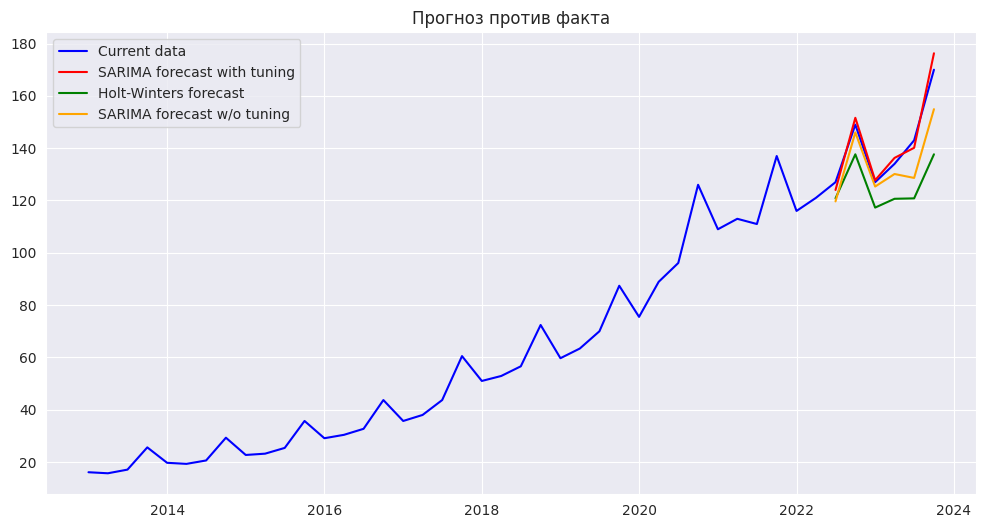

In [31]:
test['Forecast_SARIMA'] = model_sarima_best.fit(disp=False).forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(df_amazon.index, df_amazon['Billion USD'], label='Current data', color='blue')
plt.plot(test.index, test['Forecast_SARIMA'], label='SARIMA forecast with tuning', color='red')
plt.plot(test.index, forecast_hw, label='Holt-Winters forecast', color='green')
plt.plot(test_1.index, test_1['Forecast_SARIMA'], label='SARIMA forecast w/o tuning', color='orange')
plt.title('Прогноз против факта')
plt.legend()
plt.show()